In [1]:
import numpy as np
from mnist import MNIST
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
from PIL import Image
from matplotlib import pyplot as plt
import copy

In [2]:
model_30 = np.load("./temp/digit_vectors_seed_30.npy")
model_40 = np.load("./temp/digit_vectors_seed_40.npy")
model_50 = np.load("./temp/digit_vectors_seed_50.npy")

In [3]:
model_30.shape

(10, 10000)

In [17]:
def load_dataset():
    mndata = MNIST('./data/')
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, _ = map(np.array, mndata.load_testing())
    return X_train, labels_train, X_test

In [18]:
def classify(images, digit_vectors):
    similarities = cosine_similarity(images, digit_vectors)
    classifications = np.argmax(similarities, axis=1)
    return classifications

In [19]:
X_train, labels_train, _ = load_dataset()
# X_train, labels_train = shuffle(X_train, labels_train)
X_train, X_test, y_train, y_test = train_test_split(X_train, labels_train, test_size=0.33, random_state=42)

In [20]:
X_train.shape

(40200, 784)

In [21]:
X_test.shape

(19800, 784)

In [22]:
D = 10000 # dimensions in random space
IMG_LEN = 28
NUM_SAMPLES = X_train.shape[0]

In [23]:
# Transform the image vectors into the hypervectors
def get_scenes(images, proj):
    return np.dot(images[:NUM_SAMPLES, :], proj.T)

In [24]:
proj.shape

NameError: name 'proj' is not defined

In [56]:
seeds = [30, 40, 50]
models = [model_30, model_40, model_50]
results = []

for seed, model in zip(seeds, models):
    np.random.seed(seed)
    proj = np.random.randint(2, size=(D, IMG_LEN * IMG_LEN))
    proj[proj==0] = -1
    X_test_copy = copy.deepcopy(X_test)
    X_test_copy = get_scenes(X_test_copy, proj)
    X_test_copy[X_test_copy > 0] = 1
    X_test_copy[X_test_copy <= 0] = -1
    predictions = classify(X_test_copy, model)
    results.append(predictions)
    print("here")

here
here
here


In [7]:
np.save("results_30_40_50.npy", results)

NameError: name 'results' is not defined

In [ ]:
results = np.load("./temp/results_30_40_50.npy")

In [ ]:
len(y_test)

In [25]:
import pandas as pd
df = pd.DataFrame({'model_30': list(results[0]),
                   'model_40': list(results[1]),
                   'model_50': list(results[2]),
                   'y': y_test})

In [26]:
df_discrepencies = df[(df["y"] == df["model_30"]) | (df["y"] == df["model_40"]) | (df["y"] == df["model_50"])]

In [27]:
df_discrepencies = df_discrepencies[((df_discrepencies["y"] + df_discrepencies["model_30"]
                                     + df_discrepencies["model_40"] + df_discrepencies["model_50"]) 
                                     != df_discrepencies["y"] * 4)]

In [30]:
df_discrepencies.to_excel("./temp/test_discrepencies.xlsx")

In [69]:
X_test.shape

(19800, 10000)

In [53]:
data_discrepencies = X_test[list(df_discrepencies.index)]

In [54]:
len(data_discrepencies)

1054

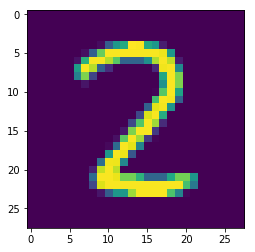

In [55]:
plt.imshow(data_discrepencies[100].reshape(28, 28), interpolation='nearest')

In [56]:
feed_idx = list(df_discrepencies.index)
feed_x_data = X_test[feed_idx]
feed_y_data = y_test[feed_idx]

In [57]:
aug_X_train = np.concatenate((X_train,feed_x_data))
aug_y_train = np.concatenate((y_train,feed_y_data))

In [58]:
D = 10000 # dimensions in random space
IMG_LEN = 28
NUM_SAMPLES = aug_X_train.shape[0]

In [59]:
print("Generating random projection...")
proj = np.random.randint(2, size=(D, IMG_LEN * IMG_LEN))
proj[proj==0] = -1

Generating random projection...


In [60]:
# print("Generating random projection...")
# proj = np.random.rand(D, IMG_LEN * IMG_LEN)
print("Generating random projection...")
seed = 50
np.random.seed(seed)
proj = np.random.randint(2, size=(D, IMG_LEN * IMG_LEN))
proj[proj==0] = -1
print(proj.shape)
def get_scene(img, proj):
    return np.dot(proj, img)

# Transform the image vectors into the hypervectors
def get_scenes(images, proj):
    print(images.shape)
    print(proj.shape)
    return np.dot(images[:NUM_SAMPLES, :], proj.T)

print("Projecting images to higher dim space...")
aug_X_train = get_scenes(aug_X_train, proj)

Generating random projection...
(10000, 784)
Projecting images to higher dim space...
(41254, 784)
(10000, 784)


In [61]:
aug_X_train[aug_X_train > 0] = 1
aug_X_train[aug_X_train <= 0] = -1

In [62]:
digit_vectors = np.zeros((10, D))
# num_count = {}
for i in range(NUM_SAMPLES):
#     num_count[y_train[i]] =  num_count.get(y_train[i], 0) + 1
    digit_vectors[aug_y_train[i]] += aug_X_train[i]
digit_vectors = np.array(digit_vectors)

In [63]:
digit_vectors[digit_vectors > 0] = 1
digit_vectors[digit_vectors <= 0] = -1

In [64]:
np.save(f'digit_vectors_seed_aug_{seed}.npy', digit_vectors)

In [65]:
def classify(images, digit_vectors):
    similarities = cosine_similarity(images, digit_vectors)
    classifications = np.argmax(similarities, axis=1)
    return classifications

In [66]:
print("Augmented Train accuracy:")
predictions = classify(aug_X_train, digit_vectors)
acc = accuracy_score(aug_y_train[:aug_X_train.shape[0]], predictions)
print(acc)

Augmented Train accuracy:
0.8039220439230135


In [67]:
print("Test accuracy:")
X_test = get_scenes(X_test, proj)
X_test[X_test > 0] = 1
X_test[X_test <= 0] = -1
predictions = classify(X_test, digit_vectors)
acc = accuracy_score(y_test[:X_test.shape[0]], predictions)
print(acc)

Test accuracy:
(19800, 784)
(10000, 784)
0.8077777777777778
